In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# import libraries:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))

#from change_of_parameters import omega_CDM_to_luisa, F_H, F_H_prime
from constants import LAMBDA, L, OMEGA_R_0, KAPPA

from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000 #km/s

from getdist import plots
import getdist
from getdist import plots, MCSamples, loadMCSamples
getdist.chains.print_load_details = False
import scipy
from scipy.integrate import simps, solve_ivp
from scipy.linalg import sqrtm
import numpy as np

from seaborn import heatmap
import pandas as pd
import emcee

import time

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hubble_parameter(z, Hs, model_name='BETA'):
    """
    Plots the Hubble parameter as a function of redshift.

    Parameters:
    z (array-like): Array of redshift values.
    Hs (array-like): Array of Hubble parameter values corresponding to the redshift values.
    model_name (str): Name of the cosmological model used for the plot title.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(z, Hs, label=f'Hubble Parameter ({model_name} Model)', color='blue', linewidth=2)

    # Enhancements
    plt.xlabel('Redshift (z)', fontsize=14)
    plt.ylabel('Hubble Parameter (H(z)) [km/s/Mpc]', fontsize=14)
    plt.title('Hubble Parameter vs Redshift', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.yscale('log')  # Optional: log scale for better visualization
    plt.xscale('log')  # Optional: log scale for better visualization
    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.tight_layout()

    # Show plot
    plt.show()


def plot_hubble_parameter_subplots(z, Hs, model_name='BETA'):
    """
    Plots the Hubble parameter and the integrand 1/(H(z)*(1+z)) as subplots.

    Parameters:
    z (array-like): Array of redshift values.
    Hs (array-like): Array of Hubble parameter values corresponding to the redshift values.
    model_name (str): Name of the cosmological model used for the plot title.
    """
    # Calculate the integrand
    integrand = 1 / (Hs * (1 + z))

    # Create a DataFrame for Seaborn
    import pandas as pd
    data = pd.DataFrame({'Redshift (z)': z, 'Hubble Parameter (H(z))': Hs, 'Integrand': integrand})

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Hubble parameter
    sns.lineplot(ax=axes[0], data=data, x='Redshift (z)', y='Hubble Parameter (H(z))', label=f'Hubble Parameter ({model_name} Model)', color='blue')
    axes[0].set_xlabel('Redshift (z)', fontsize=14)
    axes[0].set_ylabel('Hubble Parameter (H(z)) [km/s/Mpc]', fontsize=14)
    axes[0].set_title('Hubble Parameter vs Redshift', fontsize=16)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[0].set_yscale('log')  # Optional: log scale for better visualization
    axes[0].set_xscale('log')  # Optional: log scale for better visualization
    axes[0].minorticks_on()
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].tick_params(axis='both', which='minor', labelsize=10)

    # Plot integrand
    sns.lineplot(ax=axes[1], data=data, x='Redshift (z)', y='Integrand', label='Integrand 1/(H(z)*(1+z))', color='green')
    axes[1].set_xlabel('Redshift (z)', fontsize=14)
    axes[1].set_ylabel('Integrand 1/(H(z)*(1+z))', fontsize=14)
    axes[1].set_title('Integrand vs Redshift', fontsize=16)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[1].set_yscale('log')  # Optional: log scale for better visualization
    axes[1].set_xscale('log')  # Optional: log scale for better visualization
    axes[1].minorticks_on()
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].tick_params(axis='both', which='minor', labelsize=10)

    plt.tight_layout()
    plt.show()


In [3]:
#GILA model
def F_H(H, params, model):     
    lamb, L, beta, L_bar, s = params # L and L_bar have to be in units of H0^{-1}
    if model == 'GILA':
        FH = H**2 - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**(2*s)) \
                  #+ H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2)
    elif model == 'BETA':
        FH = H**2 - H**2            * beta * np.exp(-beta*(L_bar*H)**(2*s)) \
                  #+ H**8 * L**6 * lamb * np.exp(lamb*(L*H)**4)

    return FH

def F_H_prime(H, params, model):
    lamb, L, beta, L_bar, s = params # L and L_bar have to be in units of H0^{-1}

    if model == 'GILA':
        aux = np.exp(-beta*(L_bar*H)**(2*s)) * beta * (L_bar*H)**4 * (-3 + s * beta * (L_bar*H)**(2*s))
              #np.exp(lamb*(L*H)**2)       * lamb * (L*H)**6     * (4 + lamb*(L*H)**2)
    if model == 'BETA':
        aux = np.exp(-beta*(L_bar*H)**(2*s)) * beta                * (-1 + s * beta * (L_bar*H)**(2*s))
              #2 * np.exp(lamb*(L*H)**4)      * lamb * (L*H)**6  * (2 + lamb*(L*H)**4)

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime


def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, s, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar, s], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar, s],model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    #L_bar, b, H0 = physical_params
    L_bar, b, H0, s = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    
    #ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, s, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

In [4]:
omega_r = 2.47e-5 
L_bar = 0.90

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second

#z = np.linspace(0, 10, int(10e3))
z = np.linspace(0, 1000, int(10e3))
#z = np.logspace(-3, 3, int(10e3))



[0.00000000e+00 1.00010001e-01 2.00020002e-01 ... 9.99799980e+02
 9.99899990e+02 1.00000000e+03]


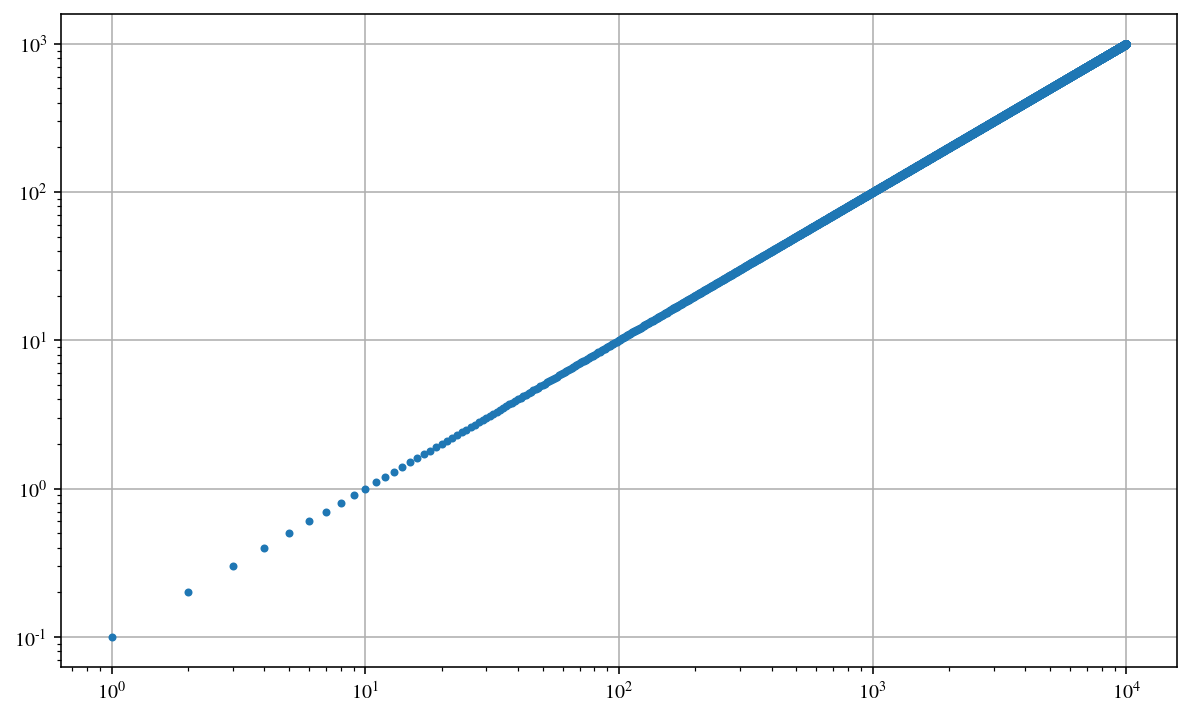

In [5]:
print(z)

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(z,'.')
plt.xscale('log')
plt.yscale('log')
plt.show()

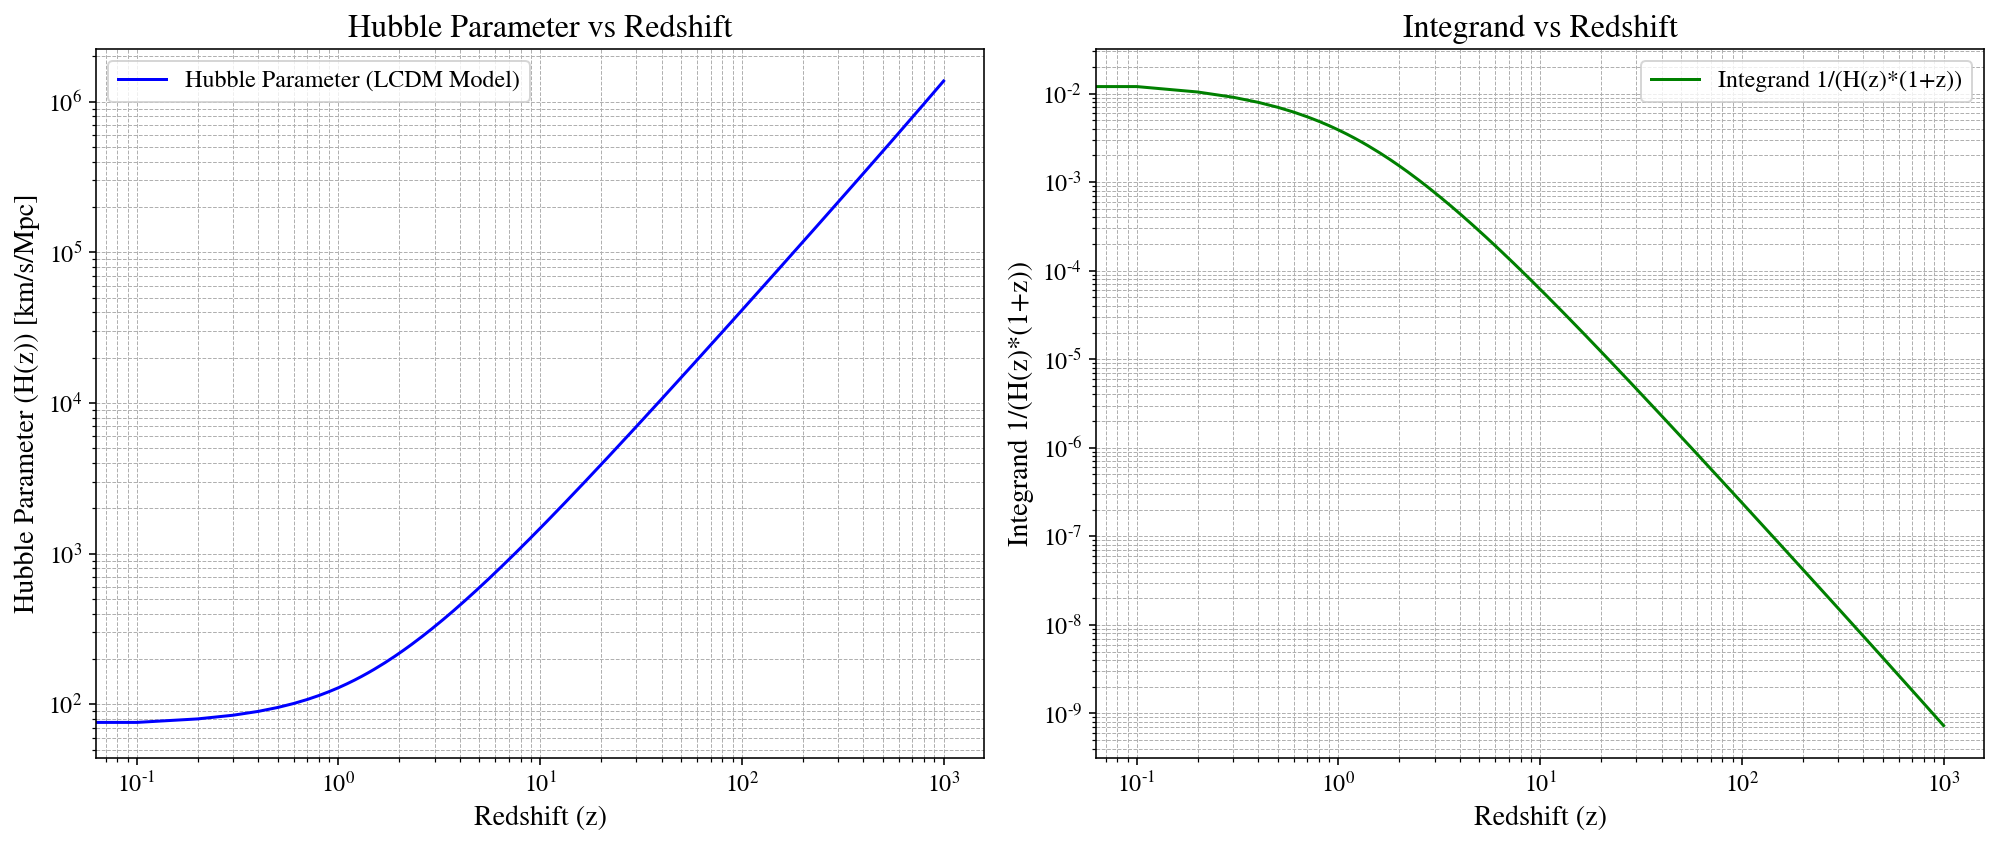

In [6]:
#LCDM MODEL
#M_abs = flat_samples_lcdm[:,0]
omega_m = 0.16290042980084599
H0 = 72.18797371868

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm
#aou_lcdm = np.zeros(len(H0))

Hubble = H0 * np.sqrt(Omega_r_lcdm * (1+z)**4 + Omega_m_lcdm * (1+z)**3 + Omega_L_lcdm )
plot_hubble_parameter_subplots(z, Hubble, model_name='LCDM')

Aou LCDM best fit=12.916077 Gyr
s=1, beta=0, Aou=9.039970 Gyr
s=1, beta=0.5, Aou=10.219743 Gyr
s=1, beta=1, Aou=11.044621 Gyr
s=2, beta=0, Aou=9.039970 Gyr
s=2, beta=0.5, Aou=10.598985 Gyr
s=2, beta=1, Aou=11.845820 Gyr
s=3, beta=0, Aou=9.039970 Gyr
s=3, beta=0.5, Aou=10.838685 Gyr
s=3, beta=1, Aou=12.581202 Gyr
s=4, beta=0, Aou=9.039970 Gyr
s=4, beta=0.5, Aou=11.022290 Gyr
s=4, beta=1, Aou=13.325282 Gyr
s=5, beta=0, Aou=9.039970 Gyr
s=5, beta=0.5, Aou=11.171360 Gyr
s=5, beta=1, Aou=14.090600 Gyr
s=6, beta=0, Aou=9.039970 Gyr
s=6, beta=0.5, Aou=11.294545 Gyr
s=6, beta=1, Aou=14.877995 Gyr
s=7, beta=0, Aou=9.039970 Gyr
s=7, beta=0.5, Aou=11.396964 Gyr
s=7, beta=1, Aou=15.685478 Gyr
s=8, beta=0, Aou=9.039970 Gyr
s=8, beta=0.5, Aou=11.482186 Gyr
s=8, beta=1, Aou=16.510298 Gyr
s=9, beta=0, Aou=9.039970 Gyr
s=9, beta=0.5, Aou=11.552922 Gyr
s=9, beta=1, Aou=17.349687 Gyr


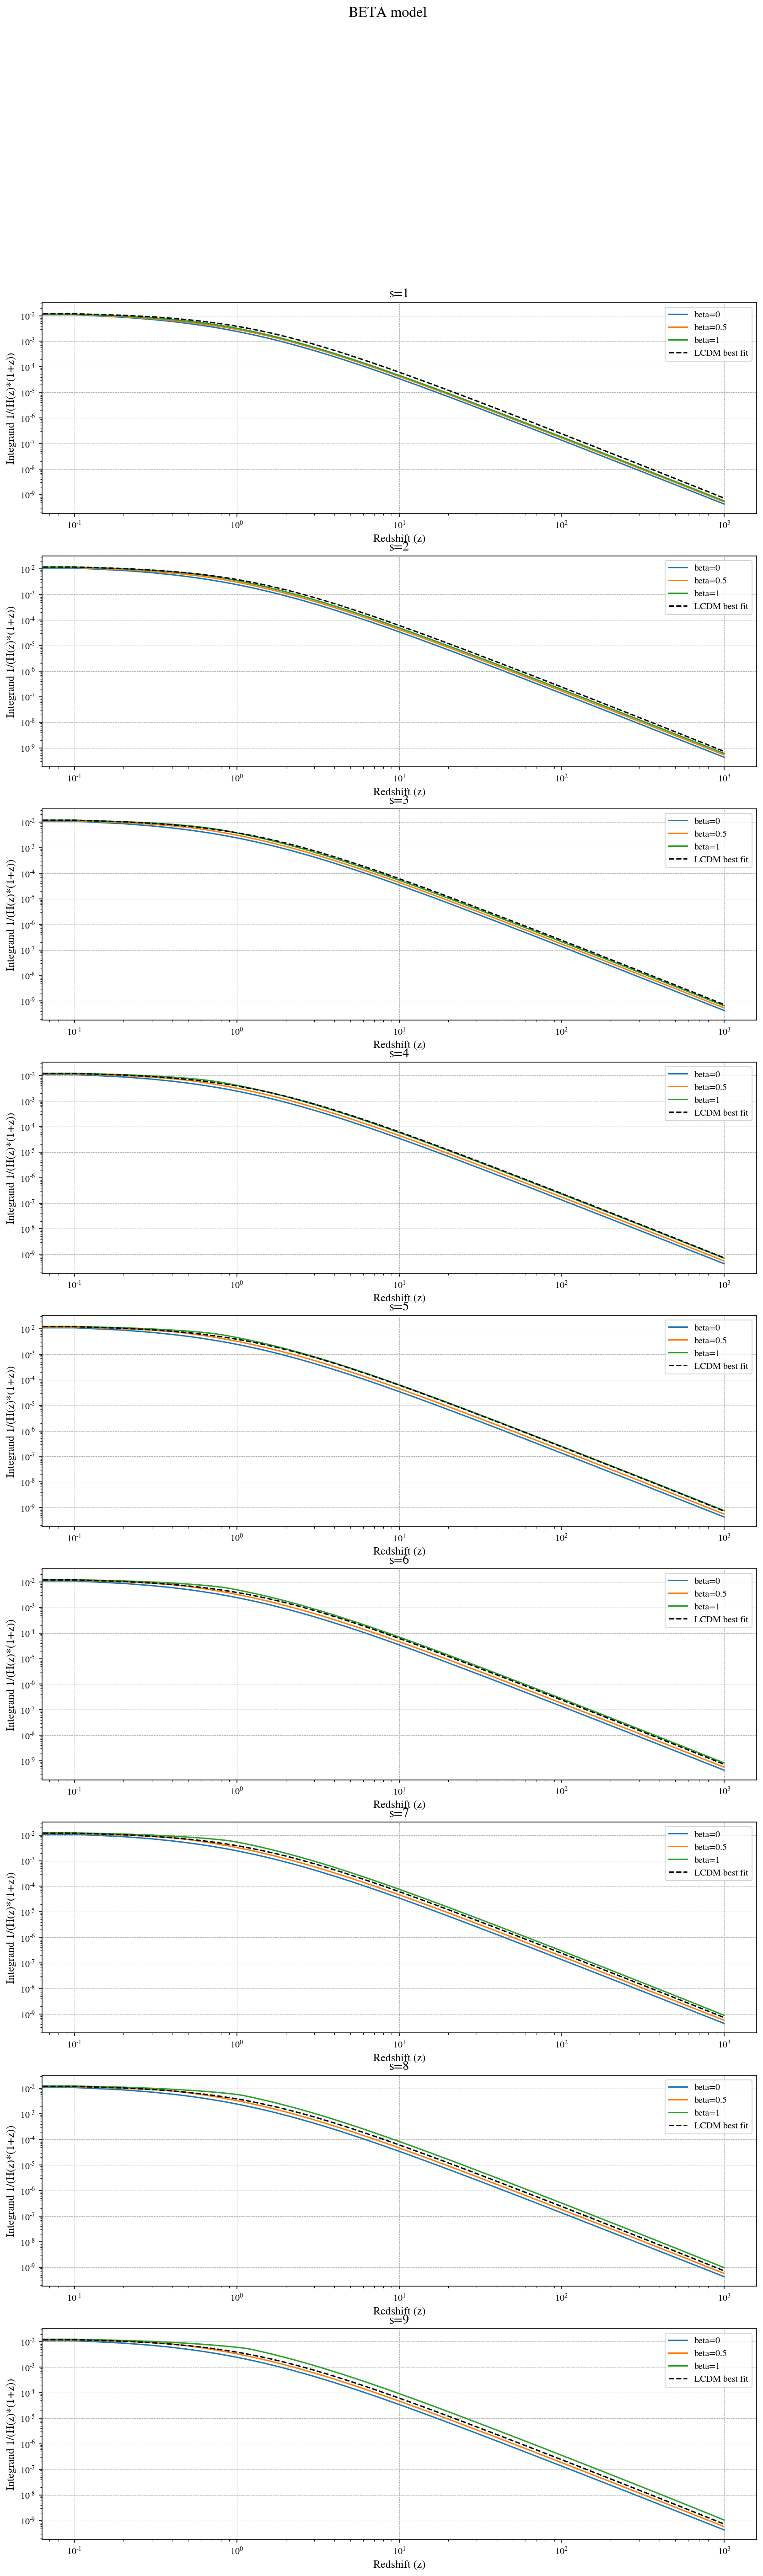

In [7]:
#BETA MODEL
s_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]
beta_values = [0, 0.5, 1]

fig, ax = plt.subplots(len(s_values), figsize=(14, 45))
fig.suptitle('BETA model', fontsize=16)


Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm
#aou_lcdm = np.zeros(len(H0))

Hubble = H0 * np.sqrt(Omega_r_lcdm * (1+z)**4 + Omega_m_lcdm * (1+z)**3 + Omega_L_lcdm )
integrand_LCDM = 1 / (Hubble * (1 + z))
aou_lcdm = inv_Hub_to_Gyr * simps(((1+z) * Hubble)**(-1), z)    
print('Aou LCDM best fit={:2f} Gyr'.format(aou_lcdm))
for i, s_val in enumerate(s_values):
    for j, beta_val in enumerate(beta_values):
        physical_params = [L_bar, beta_val, H0, s_val]
        z_final, Hs_final = integrator_GILA(physical_params, model='BETA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1])
        aou_beta = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)    
        print('s={}, beta={}, Aou={:2f} Gyr'.format(s_val,beta_val,aou_beta))
        integrand = 1 / (Hs_final * (1 + z_final))
        ax[i].plot(z_final, integrand, label=f'beta={beta_val}')
    ax[i].plot(z, integrand_LCDM, '--k', label=f'LCDM best fit')
    ax[i].set_xlabel('Redshift (z)', fontsize=12)
    ax[i].set_ylabel('Integrand 1/(H(z)*(1+z))', fontsize=12)
    ax[i].set_title(f's={s_val}', fontsize=14)
    ax[i].legend(fontsize=10)
    ax[i].grid(True, linestyle='--', linewidth=0.5)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].minorticks_on()
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
fig.savefig(os.path.join(path_figures, 'integrand_vs_redshift_BETA.png'))

Aou LCDM best fit=12.916077 Gyr
s=1, beta=0, Aou=9.039970 Gyr
s=1, beta=1, Aou=9.035633 Gyr
s=1, beta=2, Aou=9.885158 Gyr
s=2, beta=0, Aou=9.039970 Gyr
s=2, beta=1, Aou=10.344051 Gyr
s=2, beta=2, Aou=10.696758 Gyr
s=3, beta=0, Aou=9.039970 Gyr
s=3, beta=1, Aou=10.806670 Gyr
s=3, beta=2, Aou=11.469145 Gyr
s=4, beta=0, Aou=9.039970 Gyr
s=4, beta=1, Aou=11.163593 Gyr
s=4, beta=2, Aou=12.372919 Gyr
s=5, beta=0, Aou=9.039970 Gyr
s=5, beta=1, Aou=11.474868 Gyr
s=5, beta=2, Aou=13.461561 Gyr
s=6, beta=0, Aou=9.039970 Gyr
s=6, beta=1, Aou=11.752631 Gyr
s=6, beta=2, Aou=14.807575 Gyr
s=7, beta=0, Aou=9.039970 Gyr
s=7, beta=1, Aou=12.000139 Gyr
s=7, beta=2, Aou=16.558585 Gyr
s=8, beta=0, Aou=9.039970 Gyr
s=8, beta=1, Aou=12.218730 Gyr
s=8, beta=2, Aou=19.112547 Gyr
s=9, beta=0, Aou=9.039970 Gyr
s=9, beta=1, Aou=12.409495 Gyr
s=9, beta=2, Aou=24.388766 Gyr


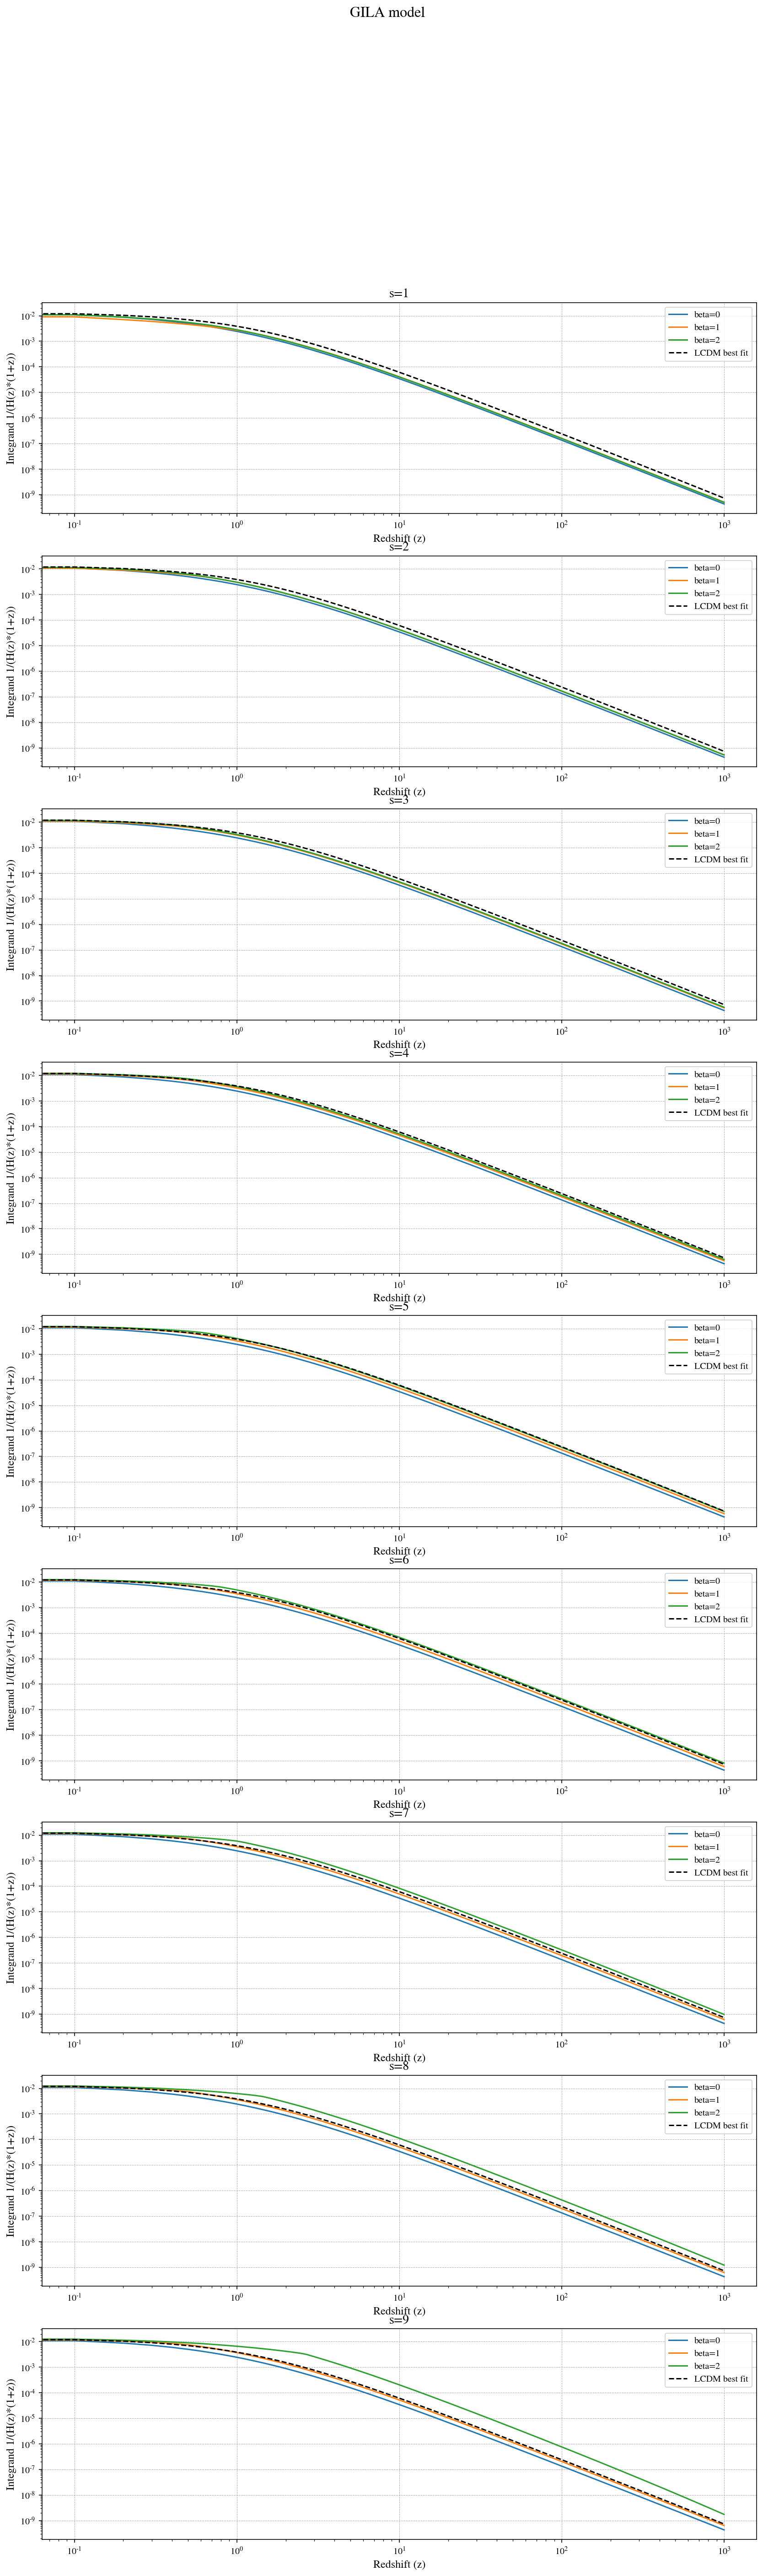

In [8]:
#GILA MODEL
s_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]
beta_values = [0, 1, 2]

fig, ax = plt.subplots(len(s_values), figsize=(14, 45))
fig.suptitle('GILA model', fontsize=16)

Hubble = H0 * np.sqrt(Omega_r_lcdm * (1+z)**4 + Omega_m_lcdm * (1+z)**3 + Omega_L_lcdm )
integrand_LCDM = 1 / (Hubble * (1 + z))
aou_lcdm = inv_Hub_to_Gyr * simps(((1+z) * Hubble)**(-1), z)    
print('Aou LCDM best fit={:2f} Gyr'.format(aou_lcdm))

for i, s_val in enumerate(s_values):
    for j, beta_val in enumerate(beta_values):
        physical_params = [L_bar, beta_val, H0, s_val]
        z_final, Hs_final = integrator_GILA(physical_params, model='GILA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1])
        aou_beta = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)    
        print('s={}, beta={}, Aou={:2f} Gyr'.format(s_val,beta_val,aou_beta))
        integrand = 1 / (Hs_final * (1 + z_final))
        ax[i].plot(z_final, integrand, label=f'beta={beta_val}')
    ax[i].plot(z, integrand_LCDM, '--k', label=f'LCDM best fit')
    ax[i].set_xlabel('Redshift (z)', fontsize=12)
    ax[i].set_ylabel('Integrand 1/(H(z)*(1+z))', fontsize=12)
    ax[i].set_title(f's={s_val}', fontsize=14)
    ax[i].legend(fontsize=10)
    ax[i].grid(True, linestyle='--', linewidth=0.5)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].minorticks_on()
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
fig.savefig(os.path.join(path_figures, 'integrand_vs_redshift_GILA.png'))